# Objective

We are asked to predict 3 months of total sales of all items/stores given 5 years of store-item sales. With this purpose in mind, we are going to apply different time series/ML techniques such as exponential smoothing, SARIMA model, iterative linear regression, TBats, and a Deep Learning model. As required for the company, the selection of the forecasting model must be based on three following factors: accuracy, explainability, and processing time.

# Overview

This notebook is organized as follows:  

1. Data Wranging

2. EDA – Exploratory Data Analysis  
  
3. Modelling and Model Evaluation:   
   a. Exponentail Smoothing  
   b. Iterative Linear Regression  
   c. SARIMA model  
   d. TBATS model  
   
4. Results
5. Conclusions

# About the data

The company disposes a dataset of 5 years of sales, from 2013 to 2017, for 50 different items at 10 different stores.  

The provided dataset has 4 columns:
* date - Date of the sale data. There are no holiday effects or store closures.
* store - Store ID
* item - Item ID
* sales - Number of items sold at a particular store on a particular date.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import time

import os
os.chdir("./data/")

df = pd.read_csv('train.csv')

In [2]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
stores = df['store'].unique()
print("Data is collected from from {} stores".format(len(stores)))
print("Stores ID:\n{} \n".format(stores))
items = df['item'].unique()

print("Data corresponds to sales of {} different items".format(len(items)))
print("Items ID:\n{}".format(items))

Data is collected from from 10 stores
Stores ID:
[ 1  2  3  4  5  6  7  8  9 10] 

Data corresponds to sales of 50 different items
Items ID:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


In [4]:
print("Sales historical data is from {} to {}".format(df['date'].min(),df['date'].max()))

Sales historical data is from 2013-01-01 to 2017-12-31


### Setup

In [5]:
# imports
#from datetime import timedelta
from IPython.display import display
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.1f}'.format
%matplotlib inline
plotsize = (13, 5)

# 1. Data Wrangling

In this section all transformations needed to use the data in machine learning models are made

In [6]:
# Cheking for proper data types:
df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [7]:
df.shape

(913000, 4)

In [8]:
# date feature must be converted to datetime type:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

### Checking for missing values:

In [9]:
for i in df.isnull().sum():
    if i != 0:
        print("There are missing values")

### Checking for duplicates:

In [10]:
if df.shape == len(df.drop_duplicates(['date','store','item'])):
    print("There are duplicates")

There are neither missing values nor duplicates

### Extracting date information

In [11]:
def transformations_date(df):
    tmp = df.reset_index()
    tmp['year'] = tmp['date'].dt.year
    tmp['week'] = tmp['date'].dt.week
    tmp['month'] = tmp['date'].dt.month
    tmp['day'] = tmp['date'].dt.day
    tmp['weekday'] = tmp['date'].dt.weekday + 1
    tmp['quarter'] = tmp['date'].dt.quarter
    return tmp

In [12]:
df = transformations_date(df)

# 2. EDA – Exploratory Data Analysis

For purposes of using different forecasting approaches, two dataframes are going to be defined: the first one containing the total item/store sales, and the second one containing the sales for itemID 1 at the storeID 1

#### Total Sales Data:

In [13]:
sales_total = df.groupby(['date','year', 'quarter', 
                          'month', 'week', 'weekday', 'day'])['sales'].sum().reset_index()
sales_total.set_index('date', inplace=True)
sales_total = sales_total.resample('D').sum() # Setting time frequency to day

sales_total.head()

,year,quarter,month,week,weekday,day,sales
date,,,,,,,
2013-01-01,2013,1,1,1,2,1,13696
2013-01-02,2013,1,1,1,3,2,13678
2013-01-03,2013,1,1,1,4,3,14488
2013-01-04,2013,1,1,1,5,4,15677
2013-01-05,2013,1,1,1,6,5,16237


#### Sales Data for itemID=1 at the store storeID=1:

In [14]:
sales_store_item = df[(df.store == 1) & (df.item == 1)]
sales_store_item.set_index('date', inplace=True)
sales_store_item = sales_store_item.resample('D').sum() # Setting time frequency to day

#sales_store_item.head()

In [15]:
print('\nUnique dates in our data: ', len(sales_total.index.unique()), 'Days')
# Calculate number of days in date range
our_date_range = sales_total.index.max() - sales_total.index.min()
print('Total days in our date range:', our_date_range.days, 'Days')


Unique dates in our data:  1826 Days
Total days in our date range: 1825 Days


### Splitting train-test datasets

In [16]:
def training_test_splitting(df, date_end_training = '2017-09-30', date_start_testing = '2017-10-01'):
    training_tmp = df.loc[:date_end_training]
    testing_tmp = df.loc[date_end_training:]
    return training_tmp, testing_tmp

In [17]:
tmp_df = df.set_index('date')
df_train_original, df_test_original = training_test_splitting(tmp_df) # for original dataset

df_train, df_test = training_test_splitting(sales_total) # for total sales analysis
df_train_11, df_test_11 = training_test_splitting(sales_store_item) # for item 1 store 1

### EDA Total Sales

<AxesSubplot:title={'center':'Daily total Sales'}, xlabel='date'>

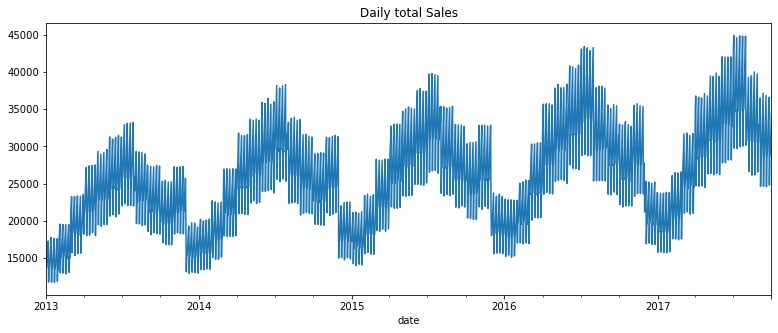

In [18]:
df_train['sales'].plot(figsize=plotsize, title='Daily total Sales')

In [19]:
def box_plots(data, lags=None):
    f, axes = plt.subplots(2, 2,figsize=(10,6), constrained_layout = True)
    f.suptitle('Total Sales') # or plt.suptitle('Main title')
    sns.boxplot(x="year", y="sales", data=data, ax=axes[0,0])
    sns.boxplot(x="quarter", y="sales", data=data, ax=axes[0,1])
    sns.boxplot(x="month", y="sales", data=data, ax=axes[1,0])
    sns.boxplot(x="weekday", y="sales", data=data, ax=axes[1,1])

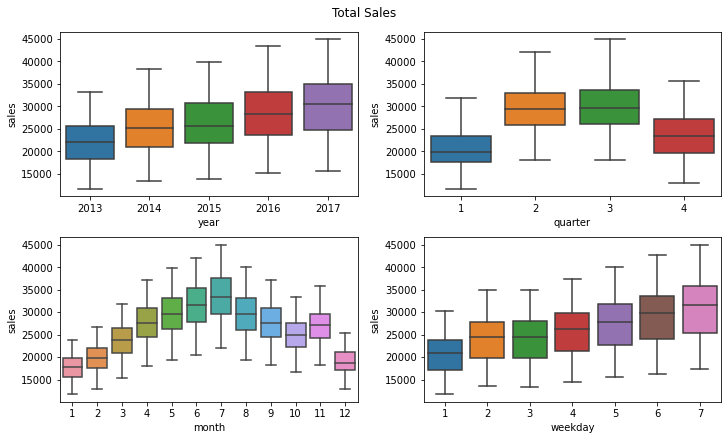

In [20]:
box_plots(df_train)

### Insights:

* There is an increasing trend in sales each year. 
   - We can notice here that 2015 sales did not increase so much with respect to 2014. 
   - median total sales seems to grow linearly

* There are seasonal patterns in the number of total sales. 
   - Total sales are increasing during the firsts two quarters of the year, reaching its maximun at July, and then decreasing untill December.
   - In the last quarter, there is a peak on November 
   - Sales grow during the week reaching its max on Sunday

**Concerning forecasting Models:**
- There is an increaing trend during the year (non-stationary time series)
- Looks like there is complex seasonality: yearly and weekly (non-stationary time series). This will make difficult for ARIMA and SARIMA models since complex seasonalities make difficult transform the serie into a stationary serie. We need a different approach



### EDA Sales for individual stores and items

<AxesSubplot:title={'center':'Annual by item'}, xlabel='year', ylabel='sales'>

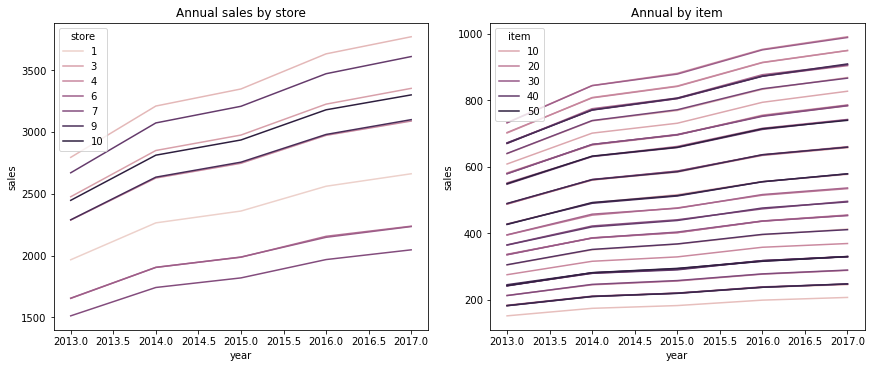

In [21]:
store_sales = df.groupby(['date','year', 'store'])['sales'].sum().reset_index()
item_sales = df.groupby(['date','year', 'item'])['sales'].sum().reset_index()

f, axes = plt.subplots(1, 2,figsize=(12,5), constrained_layout = True)
#f.suptitle('Sales') 

axes[0].set_title('Annual sales by store')
axes[1].set_title('Annual by item')

sns.lineplot(data=store_sales, x='year', y='sales', hue='store', ci = None, ax=axes[0])
sns.lineplot(data=item_sales, x='year', y='sales', hue='item',  ci = None, ax=axes[1])

<AxesSubplot:title={'center':'Annual by item'}, xlabel='date', ylabel='sales'>

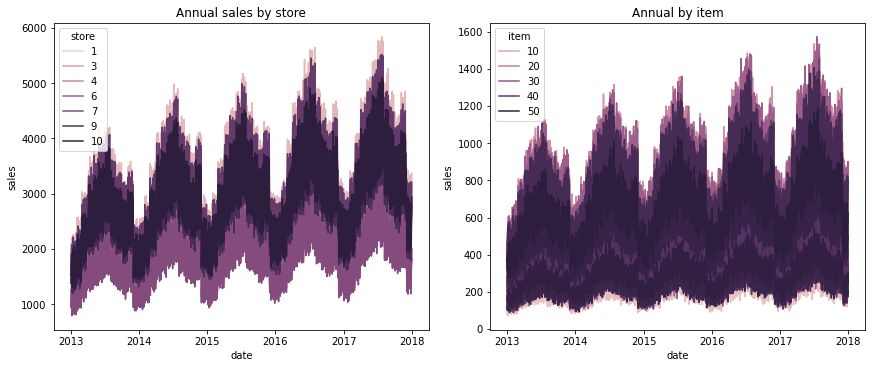

In [22]:
f, axes = plt.subplots(1, 2,figsize=(12,5), constrained_layout = True)
#f.suptitle('Sales') 

axes[0].set_title('Annual sales by store')
axes[1].set_title('Annual by item')

sns.lineplot(data=store_sales, x='date', y='sales', hue='store',  ci = None, ax=axes[0])
sns.lineplot(data=item_sales, x='date', y='sales', hue='item',  ci = None, ax=axes[1])


### Insights:

Seasonality is most-likely the same over the store and items. Therefore we can make a stationary time serie analysis over one item at one store, and model (ARIMA and SARIMA). Total sales will be obtained modelling and forecasting for each store or/and item. Although, it will represent time-consuming processing, this is important considering that the complex seasonality for total sales will not allow model with ARIMA and SARIMA. 

# 3. Modeling

This section shows modelling, and model evaluation for:

   a. Exponential Smoothing model  
   b. SARIMA model  
   c. Iterative Linear Regression model  
   d. TBATS model   

Before starting to present modelling, some functions are going to be define for model evaluation

In [23]:
def error_plotting(df_train, df_test, pred_column, model, model_title):
    #pred_column = 'pre_'+model
    title = 'Forecast - '+model_title
    errors = 'errors_'+model
    df_train = df_train.reset_index()
    df_test = df_test.reset_index()
    
    df_test = df_test[['date', 'sales', pred_column]]
    df_test[errors] = df_test['sales'] - df_test[pred_column]
    df_test.insert(0, 'model', model)

    df_train = df_train.set_index('date')
    df_test = df_test.set_index('date')
    
    plt.figure(figsize=(14,5))
    plt.plot(df_train.index, df_train['sales'], label='Train')
    plt.plot(df_test.index, df_test['sales'], label='Test')
    plt.plot(df_test.index, df_test[pred_column], label=title)
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.title(title)
    plt.show()
    
    # Plot with errors
    plt.figure(figsize=(14,5))
    plt.plot(df_test.index, df_test['sales'], label='Test')
    plt.plot(df_test.index, df_test[pred_column], label=title)
    plt.plot(df_test.index, df_test[errors], label='error')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.title(title)
    plt.show()
    
    return df_test

In [24]:
def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=df_test['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

def results(df_test, pred_column, error_column, mape=mape):
    result = df_test.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=(pred_column, 'sum'),
                                          overall_error=(error_column, 'sum'),
                                          MAE=(error_column, mae),
                                          RMSE=(error_column, rmse), 
                                          MAPE=(error_column, mape))
    return result
    

## a. Exponential Smoothing (Holt-Winters) model

This model is useful for estimating trends, and seasonality forecasting a current value based on past values.
 
The most recent observations are predominant for the model, while the weight drops exponentially for further values in the past. 

This model was trained for a time window of 365 days considering the pattern per year.

In [25]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [26]:
start_time = time.time()

model_hw = ExponentialSmoothing(df_train.sales, trend='add', seasonal='add', seasonal_periods=365)
model_hw_fit = model_hw.fit(use_boxcox=False, remove_bias=False, optimized=True)
df_test['pred_hw'] = pd.Series(model_hw_fit.predict(start=df_test.index[0], end=df_test.index[-1]))

end_time = time.time()

/home/felipe/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


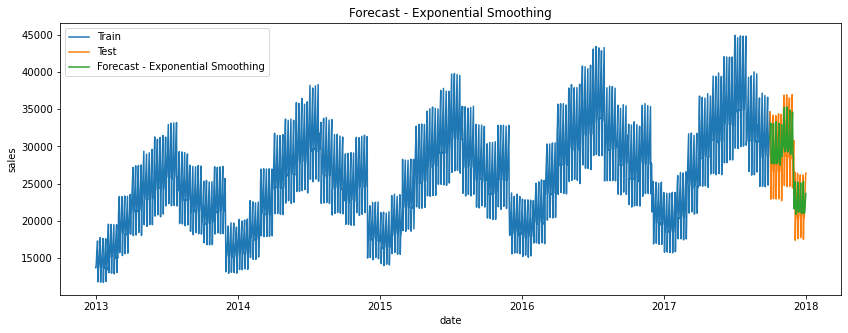

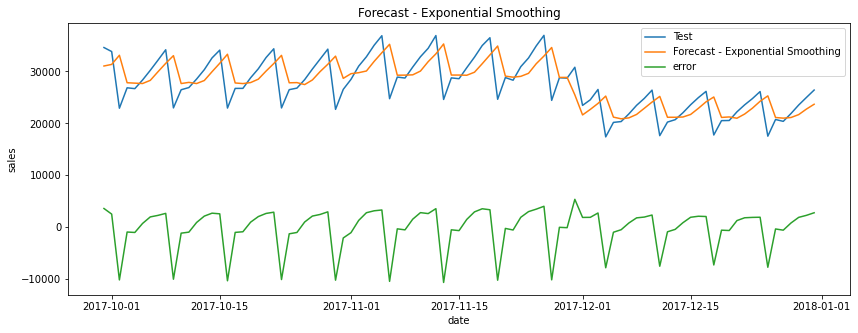

In [27]:
df_test_hw = error_plotting(df_train, df_test, 'pred_hw','hw', 'Exponential Smoothing')

In [84]:
result_hw = results(df_test_hw, 'pred_hw', "errors_hw")
result_hw

,total_sales,total_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
hw,2549790,"2,571,161.5","-21,371.5","2,859.5","4,059.4",10.4


In [29]:
print("Execution time of model is: {}".format(end_time - start_time))

Execution time of model is: 0.7165510654449463


## b. Iterative Linear Regression

The Iterative linear model consists on iterate over the days we want to predict sales. In other words, we construct a linear model, predict sales, and based on the information for the predicted sale, we predict the next day. To make the model accurate, this model considers past sale values, rolling sale values, and rolling sale errors to consider any trend or seasonality.

In summary, the steps are:
1. Get past values and past error information.
2. Training the model using past sale values (lr first iteration)
3. Predict daily sales
4. Get rolling sales mean and rolling sales error using the predicted sales.
5. Train the model considering rolling values and errors (lr model second iteration)  
6. Predict daily sales

**1. Get past values and past error information.**

In [30]:
def transformations_lag(df):
    for i in range(1,8):
        lag_i = 'lag_' + str(i)
        df[lag_i] = df.sales.shift(i)
    
    # Rolling window
    df['rolling_mean'] = df.sales.rolling(window=7).mean()
    df['rolling_max'] = df.sales.rolling(window=7).max()
    df['rolling_min'] = df.sales.rolling(window=7).min()
    df['rolling_std'] = df.sales.rolling(window=7).std()
    return df

In [31]:
df_forecast_dates = pd.DataFrame({'date':pd.date_range(start='2018-01-01', end='2018-03-31')})
forecast_transf_date = transformations_date(df_forecast_dates)

tmp = pd.concat([sales_total.reset_index(), forecast_transf_date], axis=0).sort_values('date')

lr_tmp = transformations_lag(tmp)
lr_tmp = lr_tmp.set_index('date')
lr_tmp = lr_tmp.loc['2013-01-08':]

In [32]:
# Train-test splitting
df_sales = lr_tmp[['year', 'week', 'month', 'day', 'weekday', 'quarter',
       'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'rolling_mean', 'rolling_max',
       'rolling_min', 'rolling_std', 'sales']]

df_train_tmp = df_sales.loc[:'2017-09-30']
df_test_tmp = df_sales.loc['2017-10-01':'2017-12-31']

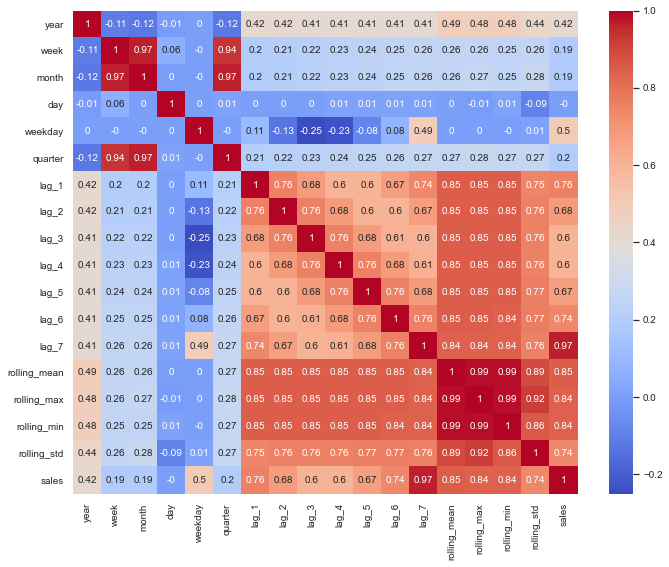

In [33]:
plt.figure(figsize=(10,8))
sns.set(style="white", font_scale = 0.9)
sns.heatmap(data= df_train_tmp.corr().round(2), cmap='coolwarm', annot=True,
annot_kws={"size":10} )

plt.tight_layout()
plt.show()

**2. Training the model using past sale values (lr first iteration)**

In [34]:
from sklearn import linear_model

In [35]:
df_train_lr = df_train_tmp.reset_index()
df_test_lr = df_test_tmp.reset_index()

In [36]:
def lr_model(predictors, df_train):
    X_train = df_train.drop(['date','sales'], axis=1)
    X_train = X_train[predictors]
    #print(X_train.head())
    y_train = df_train['sales'].values
    
    regression = linear_model.LinearRegression()
    regression.fit(X_train,y_train)
    return regression

In [37]:
predictors = ['year', 'week', 'month', 'day', 'weekday', 'quarter', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7']
lr = lr_model(predictors, df_train_lr)

**3. Predict daily sales.**  
**4. Get rolling sales mean and rolling sales error using the predicted sales**

In [38]:
def iterative_prediction(predictors, lr_model, df_test, start_date, end_date):
    while start_date <= end_date:
        df_test.loc[:start_date]
        df_test = transformations_lag(df_test)

        row_to_predict = df_test.loc[start_date:start_date]
        row = row_to_predict[predictors]

        prediction = lr_model.predict(row)
        df_test['sales'].loc[start_date] = prediction[0]

        start_date += timedelta(days=1)

In [39]:
df_test_lr = lr_tmp

start_date = datetime(2017, 9, 30)
end_date = datetime(2018, 3, 31)
iterative_prediction(predictors, lr, df_test_lr, start_date, end_date)

**5. Train the model considering rolling values and errors (lr model second iteration)**


In [40]:
predictors = ['year', 'month', 'weekday', 'lag_1', 'lag_2', 'lag_6', 'lag_7', 'rolling_mean',
       'rolling_max', 'rolling_min', 'rolling_std']
lr_2 = lr_model(predictors, df_train_lr)

**6. Predict daily sales**

In [41]:
start_date = datetime(2017, 9, 30)
end_date = datetime(2018, 3, 31)
iterative_prediction(predictors, lr_2, df_test_lr, start_date, end_date)

In [42]:
df_test_tmp['pred_lr'] = df_test_lr['sales']

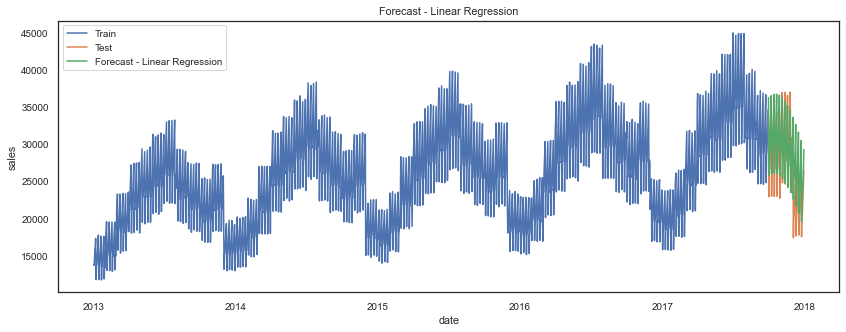

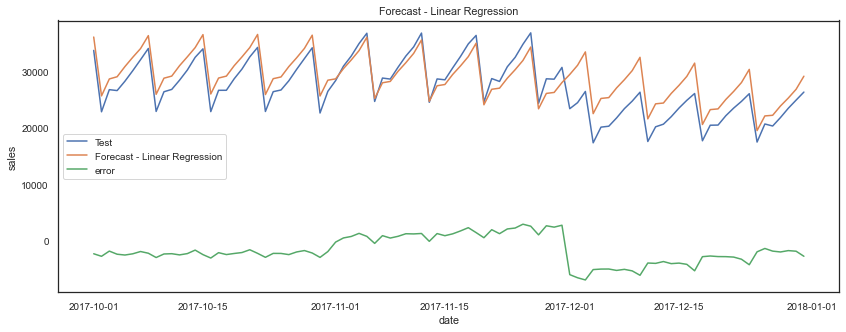

In [43]:
df_test_lr = error_plotting(df_train, df_test_tmp, 'pred_lr','lr', 'Linear Regression')

In [44]:
result_lr = results(df_test_lr, 'pred_lr', "errors_lr")
result_lr

,total_sales,total_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
lr,"2,515,167.0","2,673,875.5","-158,708.5","2,575.3","2,973.4",9.3


## c. SARIMA model

SARIMA stands for

**S**easonality aspect: It deals with seasonality.  
**AR** Autoregressive: It deals with correlation with past values. This means that the current value depends linearly on past values.  
**I** (Integrated): Differentiating data technique used in order to remove trends.  
**MA** (Moving average): The current value depends linearly on past errors.  

So, basically, this models attacks the main problems forecasting non-stationary time series:

Trends (not constant mean, not constant variance)
Seasonality (periodic patterns)
Autocorrelation (constant correlation with past values)

For SARIMA modelling is mandatory to transform our time series data into a stationary serie


For non-stationar series, the approche is:  
1 Identify sources of non-stationarity  
2 Transform series to stationary  
3 Build models with stationary series  

As mentioned before, total sales time series contains complex seasonal patterns, for that reason, the approach here is model one item sales at one store. These allows to deal with seasonal patterns for just one product instead all possible particular seasonal patterns for each product/store. 

In [45]:
from scipy.stats import normaltest
from scipy import stats
import statsmodels.api as sm

**1. Identifying Stationarity**

In order to check if a serie is stationary we must consider:

1. Constant mean (no trent)
2. Constant variance
3. Constant autocorrelation structure 
4. No periodic components

Dickey-Fuller Test is a statistical test in order to check with what confidence level we accept or reject the non-stationary hypothesis

The more negative ADF value, more confident we are of having a stationary time serie:
Check if we reject null hypothesis (non-stationay serie):   
- If p-value is close to zero, we reject the non-stationay hypothesis
- **critical_values** variable provides test statistic threholds for common significant levels. Here we see a test statistic of roughly -2.86 and lower is sufficient to reject the null (non-stationay) using a significance level of 5%. 

**Let's check if our serie is stationary for item = 1 sales at the store 1**

In [46]:
df_train_bystore, df_test_bystore = training_test_splitting(sales_store_item) 

In [47]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def Identifying_stationarity(df):
    rolling_mean = df.rolling(window=365).mean()
    rolling_std = df.rolling(window=365).std()

    plt.figure(figsize=(15,5))
    plt.plot(df, color='skyblue', label='Original Series')
    plt.plot(rolling_mean, color='black', label='Rolling Mean')
    plt.plot(rolling_std, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()
    
    #Dickey-Fuller Test
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df, regression='c')
    print("ADF: ", adf)
    print("p-value:", pvalue)
    print("number of observations = {}".format(nobs))
    print(critical_values)
    
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(df, ax=ax[0], lags=40)
    ax[1] = plot_pacf(df, ax=ax[1], lags=40)

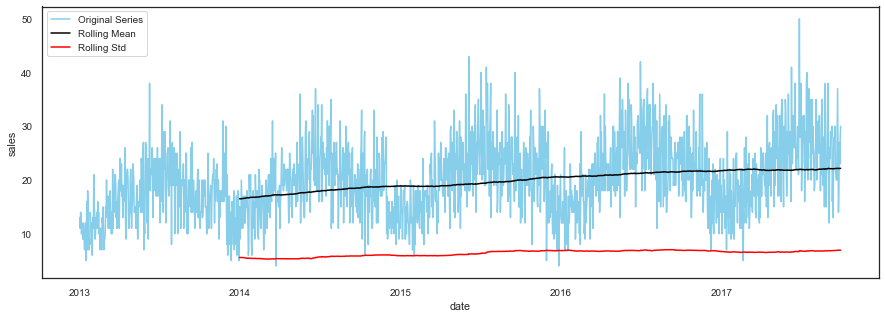

ADF:  -2.936551114312772
p-value: 0.041259717735203844
number of observations = 1710
{'1%': -3.434179908502461, '5%': -2.863231689892687, '10%': -2.567670609760268}


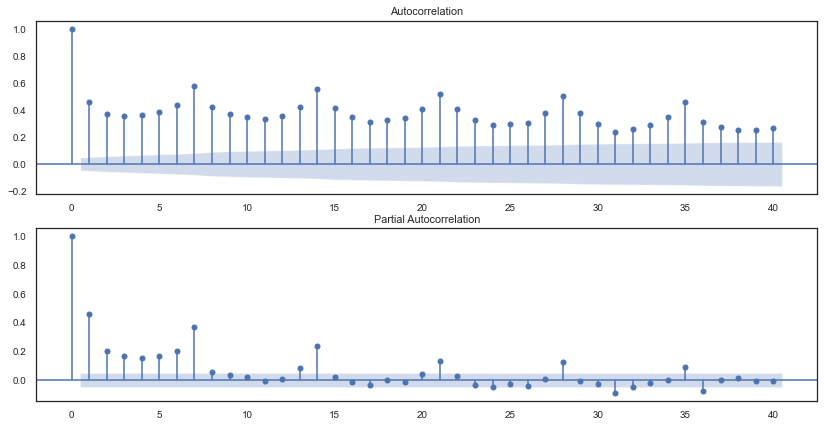

In [48]:
Identifying_stationarity(df_train_bystore.sales)

**Insights about the model**  


For SARIMA model parameters are (6,1,0), because:

* Trend can be removed with differentiation technique (1 lag)
* From Partial Autocorrelation plot we can conclude that there is a strong autocorrelation for a lag=6 (p=6)

Regarding the seasonal parameters (6,1,0,7):

* There is a weekly pattern where sales are strongly autocorrelated to the daily sales during the week. (M=7)


**Sales by store**

In [89]:
store1_sales = store_sales[store_sales.store == 1]
store1_sales = store1_sales.set_index('date')
df_train_bystore, df_test_bystore = training_test_splitting(store1_sales) # for item 1 store 1

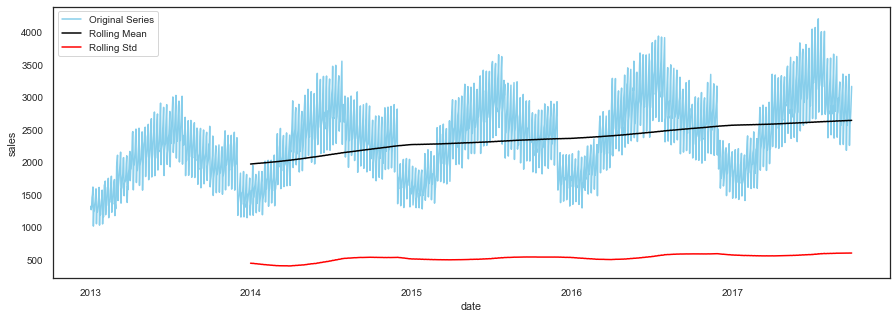

ADF:  -2.7440856870363555
p-value: 0.06671523028504117
number of observations = 1711
{'1%': -3.434177666727206, '5%': -2.8632307003234203, '10%': -2.5676700828345895}


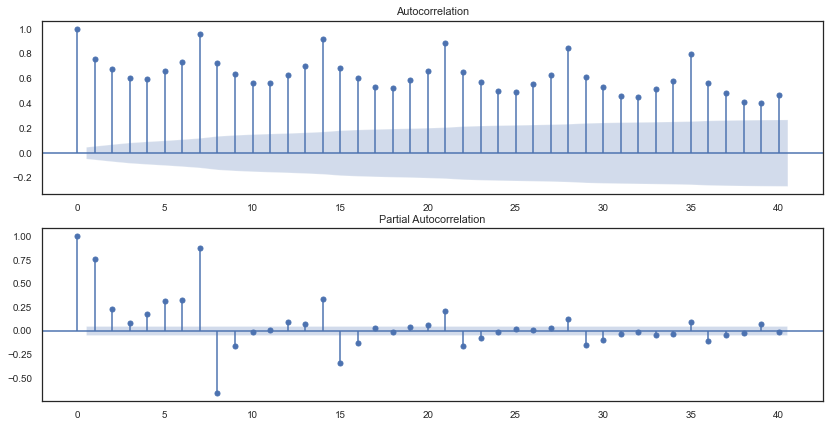

In [54]:
Identifying_stationarity(df_train_bystore.sales)

In [55]:
sar = sm.tsa.statespace.SARIMAX(df_train_bystore.sales, 
                                order=(6,1,0), 
                                seasonal_order=(3,1,0,7), 
                                frequency='D',
                                trend='c').fit()


/home/felipe/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/felipe/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [94]:
def plots(data, lags=None):
    plt.figure(figsize=(14,5))
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

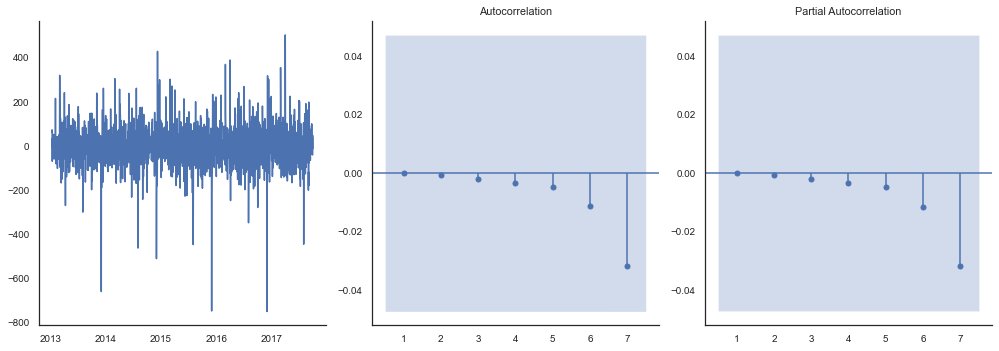

In [56]:
plots(sar.resid[sar.loglikelihood_burn:], lags=7)

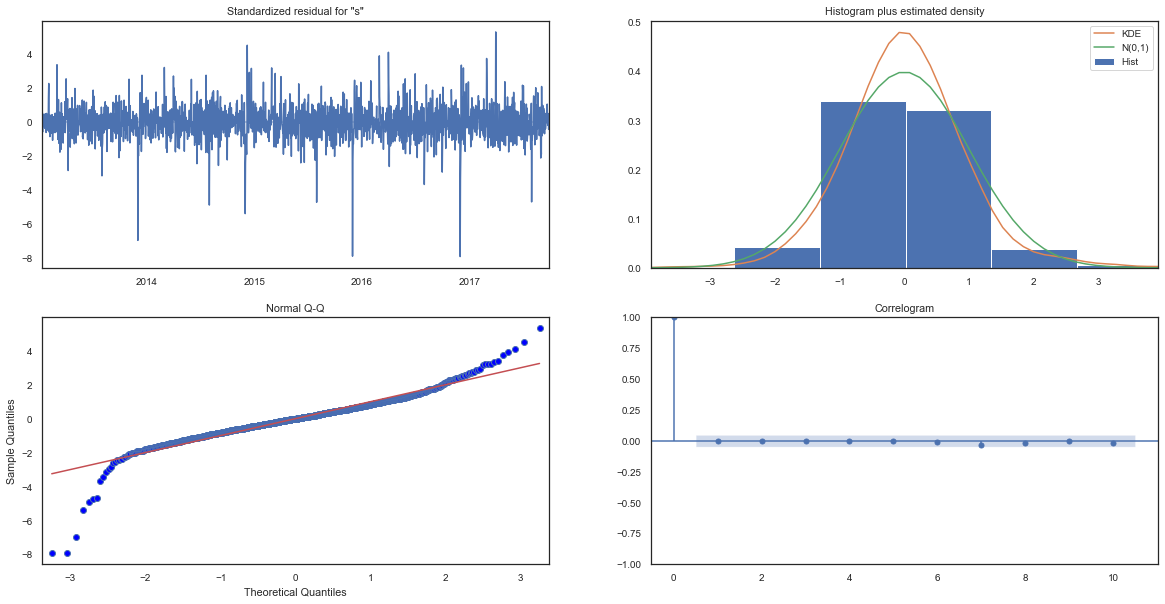

In [57]:
sar.plot_diagnostics(figsize = (20,10),);

**SARIMA modelling for each store**

In [58]:
df_test_sarima = df_test

In [59]:
start_time = time.time()

tmp = store_sales.set_index('date')

for store in range(1,11):
    store_tmp = tmp[tmp.store == store]
    store_sales_tmp = store_tmp.resample('D').sum()
    df_train_bystore, df_test_bystore = training_test_splitting(store_sales_tmp)
    sar = sm.tsa.statespace.SARIMAX(df_train_bystore.sales, 
                                order=(6,1,0), 
                                seasonal_order=(3,1,0,7), 
                                frequency='D',
                                trend='c').fit()
    
    var = 'pre_store_'+str(store)
    df_test_sarima[var] = sar.predict(start = df_test_sarima.index[0], end= df_test_sarima.index[-1])  

end_time = time.time()
print("Execution time of model is: {:.2f} seconds".format(end_time - start_time))

Execution time of model is: 76.65 seconds


In [67]:
df_test_sarima['pred_sarima'] = df_test_sarima['pre_store_1'] + df_test_sarima['pre_store_2'] + \
                                df_test_sarima['pre_store_3'] + df_test_sarima['pre_store_4'] + \
                                df_test_sarima['pre_store_5'] + df_test_sarima['pre_store_6'] + \
                                df_test_sarima['pre_store_7'] + df_test_sarima['pre_store_8'] + \
                                df_test_sarima['pre_store_9'] + df_test_sarima['pre_store_10']

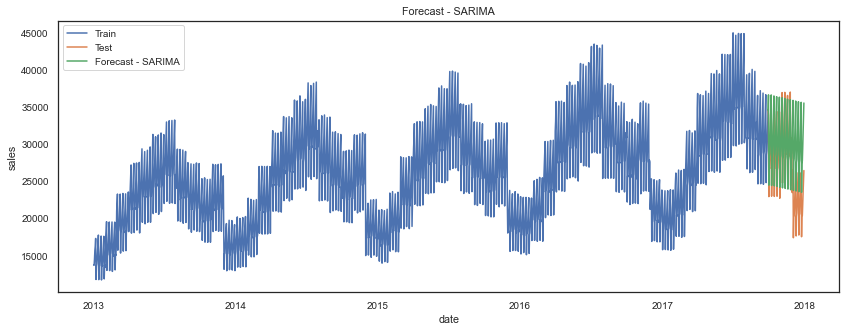

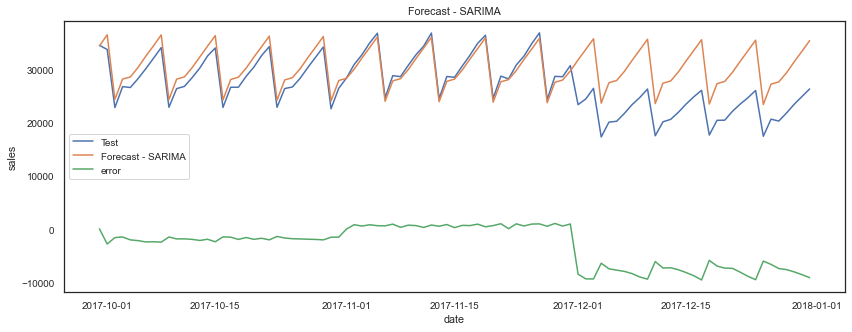

In [61]:
df_test_sarima_r = error_plotting(df_train, df_test_sarima, 'pred_sarima','sarima', 'SARIMA')

In [85]:
result_sarima = results(df_test_sarima_r, 'pred_sarima', "errors_sarima")
result_sarima

,total_sales,total_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
sarima,2549790,"2,829,404.5","-279,614.5","3,473.1","4,736.3",12.7


# TBATS

TBATS stands for:  

**T**rigonometric seasonality,   
**B**ox-Cox transformation,   
**A**RMA errors,   
**T**rend and   
**S**easonal components  

This method is based on the exponential smoothing, where predictions are made considering exponential weights for past values.  TBATS model includes the seasonality as Fourier series. 

In [ ]:
#pip install tbats

In [73]:
from tbats import TBATS, BATS
# Fit the model
estimator = TBATS(seasonal_periods=(7, 365.25))
# Forecast 365 days ahead

In [74]:
start_time = time.time()
tmp = df_train['sales'].loc['2015-01-01':] # Used a slice of the trainning data for time processing optimization
model = estimator.fit(tmp)
end_time = time.time()
print("Execution time of model is: {}".format(end_time - start_time))

Execution time of model is: 329.8679277896881


In [75]:
df_test['pred_TBATS'] = model.forecast(steps=93)

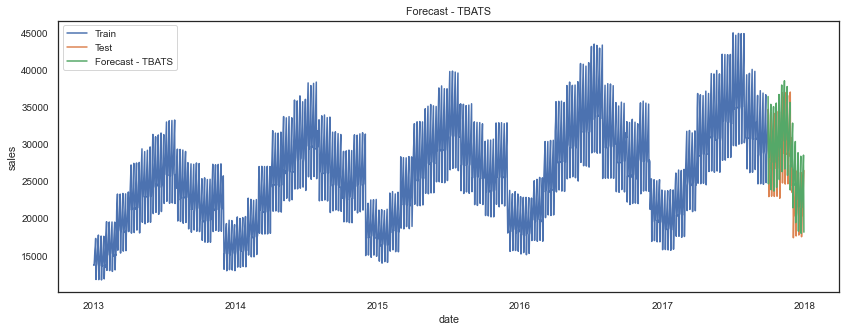

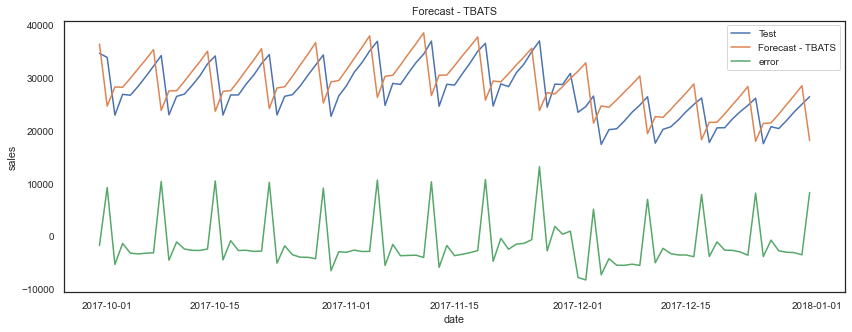

In [76]:
df_test_tbats = error_plotting(df_train, df_test, 'pred_TBATS','TBATS', 'TBATS')

In [86]:
result_tbats = results(df_test_tbats, 'pred_TBATS', "errors_TBATS")
result_tbats

,total_sales,total_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
TBATS,2549790,"2,673,353.9","-123,563.9","4,208.6","5,011.3",15.4


# Results and Conclusions

In [88]:
results = pd.concat([result_hw, result_lr, result_sarima, result_tbats])
results

,total_sales,total_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
hw,"2,549,790.0","2,571,161.5","-21,371.5","2,859.5","4,059.4",10.4
lr,"2,515,167.0","2,673,875.5","-158,708.5","2,575.3","2,973.4",9.3
sarima,"2,549,790.0","2,829,404.5","-279,614.5","3,473.1","4,736.3",12.7
TBATS,"2,549,790.0","2,673,353.9","-123,563.9","4,208.6","5,011.3",15.4


1. Although the iterative linear regression model shows the lower errors. However, this model could easily overfit our time series since it highly depends on past values, and rolling values
2. HW (Exponential Smoothing) shows the second lower errors. It is highly recomended due to its low time processing.
3. Alhotugh SARIMA model was perform by store it shows a relative low error. It explains clearly the trends and seasonal patterns. If this model is applied for each item and store, it will pick up easily the trends and patterns characteristic for each item sales at each store. Concerning the processing time, it is relative low for fitting sales for each item/store (5 min in a regular machine). Due to its explainability, relative low processing time, this model is recommended
4. TBATs model allows to deal with complex seasonal patterns. It's accuracy could improve considerably using the full trainning dataset, but its processing time is really high compared with other models.
5. Deep Learning models were excluded from this analysis since they are basically a 'black box', and would be impossible to get insights about the trends or patterns. So, They will have a high accuracy, but the costs are the explanability and the processing time. 

**In summary, the recommended models are:**
1. SARIMA (explanability)
2. Exponential Smoothing (accuracy, time processing)

You can see the low error for the SARIMA model applied for one item sales at one store (itemID = 30, storeID = 6)

In [170]:
sales_store_item = df[(df.store == 6) & (df.item == 30)]
sales_store_item.set_index('date', inplace=True)
sales_store_item = sales_store_item.resample('D').sum() # Setting time frequency to day

df_train_11, df_test_11 = training_test_splitting(sales_store_item) # for item 1 store 1

In [171]:
sar = sm.tsa.statespace.SARIMAX(df_train_11.sales, 
                                order=(6,1,0), 
                                seasonal_order=(6,1,0,7), 
                                frequency='D',
                                trend='c').fit()

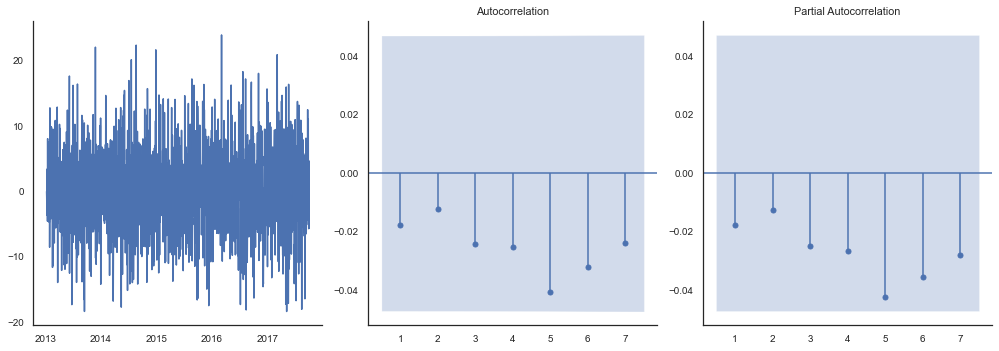

In [172]:
plots(sar.resid[sar.loglikelihood_burn:], lags=7)

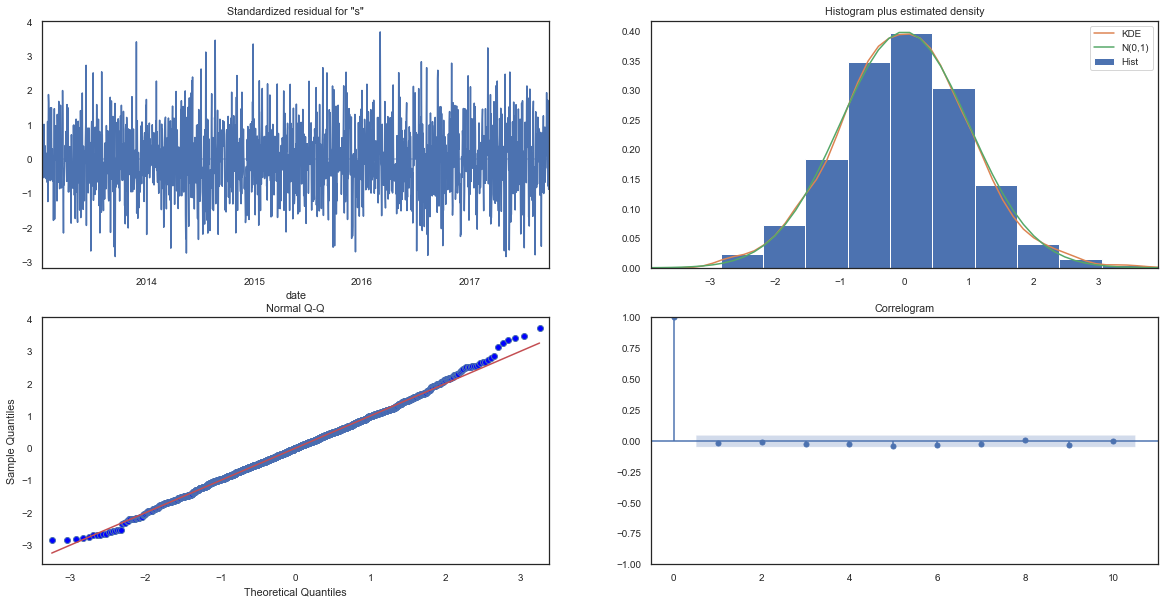

In [173]:
sar.plot_diagnostics(figsize = (20,10),);

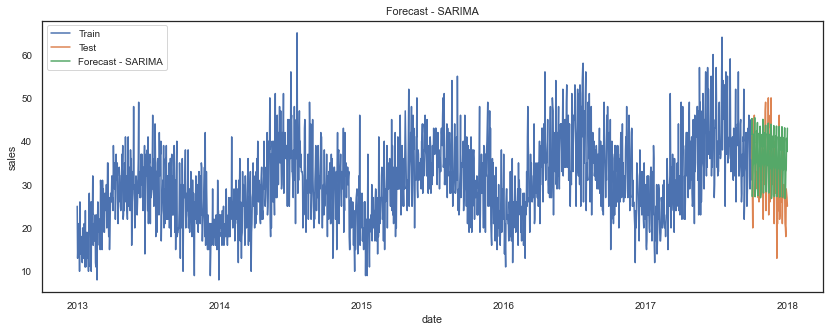

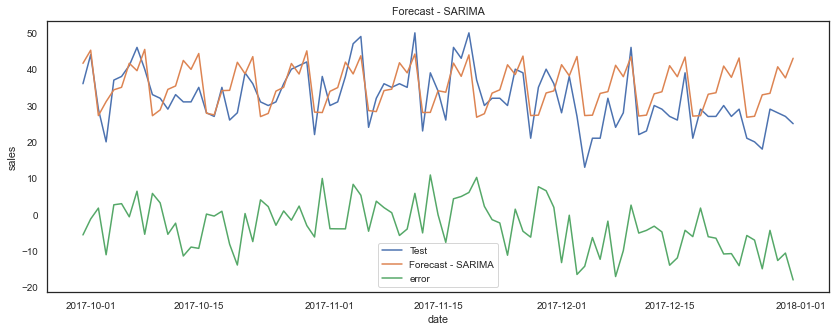

In [174]:
#df_test_sarima_storeitem = df_test_11
df_test_11['pred_sarima_11'] = sar.predict(start = df_test_11.index[0], end= df_test_11.index[-1])  
df_test_sarima_11 = error_plotting(df_train_11, df_test_11, 'pred_sarima_11','sarima_11', 'SARIMA')

In [175]:
def mape_bystore(err, sales=df_test_11['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

df_test_sarima_11.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sarima_11', 'sum'),
                                          overall_error=('errors_sarima_11', 'sum'),
                                          MAE=('errors_sarima_11', mae),
                                          RMSE=('errors_sarima_11', rmse),
                                          MAPE=('errors_sarima_11', mape_bystore))

,total_sales,total_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
sarima_11,2993,"3,300.2",-307.2,6.1,7.5,18.9


# Appendix

This section shows why was not possible to apply SARIMA model for the total sales time serie

In [78]:
df_train, df_test = training_test_splitting(sales_total) # for total sales analysis

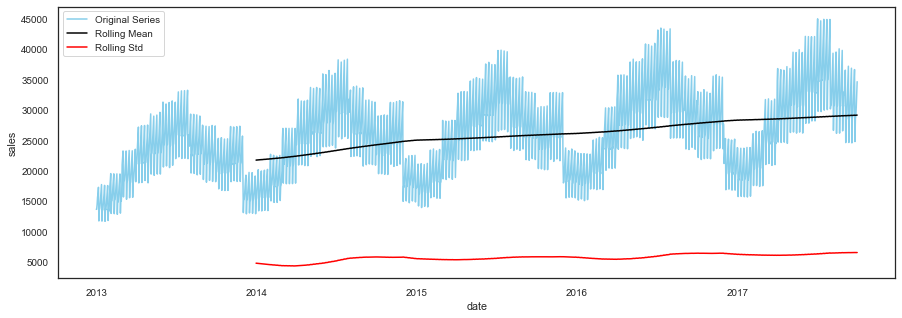

ADF:  -2.8379189016025586
p-value: 0.05305813293150783
number of observations = 1712
{'1%': -3.434175427574795, '5%': -2.8632297119111967, '10%': -2.567669556525133}


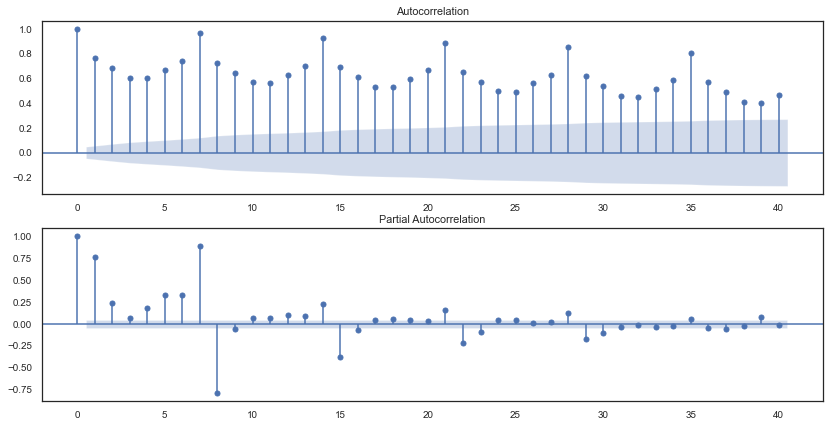

In [79]:
Identifying_stationarity(df_train.sales)

It is not stationary for several reasons:

1. There is a trend
2. There is a constant autocorrelation
3. There is a seasonal component
4. According to ADF value, our time serie is stationary with a CL of 90%. We look for a higher CL 

**2. Transformting to a Stationary Time Series**

The most important transformation to make the serie stationary is concerning to the seasonability. Seasonal or cyclical patterns can be removed by substracting periodical values. Therefore, a difference transformation must be done considering that data is 12-month seasonal, substracting the series with a 12-lag difference series will give a “flatter” series. Since we have aggregated the data to each day-level, we will shift by 1.

**Difference transformation**

In [80]:
difference = df_train.sales - df_train.sales.shift(1)
difference = pd.DataFrame(difference.dropna(inplace=False))

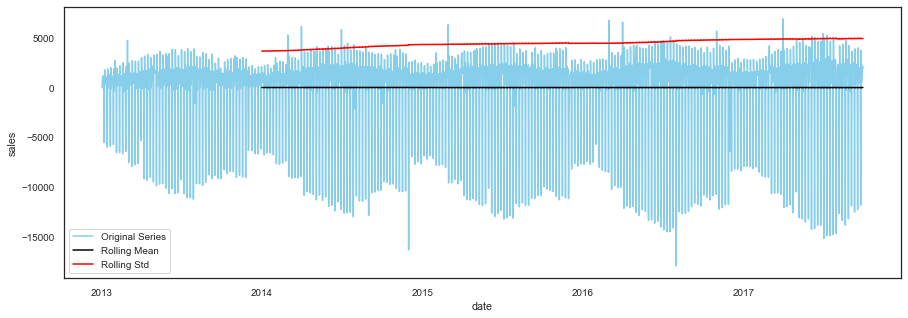

ADF:  -8.736498873004486
p-value: 3.0900861458720145e-14
number of observations = 1707
{'1%': -3.4341866496114535, '5%': -2.8632346655630943, '10%': -2.567672194245481}


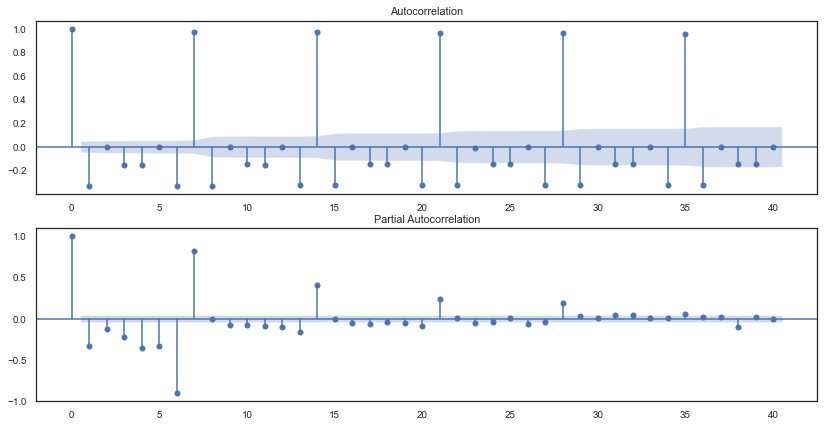

In [81]:
Identifying_stationarity(difference)

Althoug p-value is close to zero, we can see from the distribution at the top that there is a remaining seasonality that would cause problems using our SARIMA modelling. Additionally, there is still a week autoorrelation due to this seasonality. 

**Decomposition transformation**

In [82]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decomposed_time_series(df, model, period):
    ss_decomposition = seasonal_decompose(x=df, model=model, period=period)
    estimated_trend = ss_decomposition.trend
    estimated_seasonal = ss_decomposition.seasonal
    estimated_residual = ss_decomposition.resid
    return estimated_trend, estimated_seasonal, estimated_residual
    
def decomposed_plots(df, estimated_trend, estimated_seasonal, estimated_residual):
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(5)
    fig.set_figwidth(15)

    axes[0].plot(df, label='Original')
    axes[0].legend(loc='upper left');

    axes[1].plot(estimated_trend, label='Trend')
    axes[1].legend(loc='upper left');

    axes[2].plot(estimated_seasonal, label='Seasonality')
    axes[2].legend(loc='upper left');

    axes[3].plot(estimated_residual, label='Residuals')
    axes[3].legend(loc='upper left');

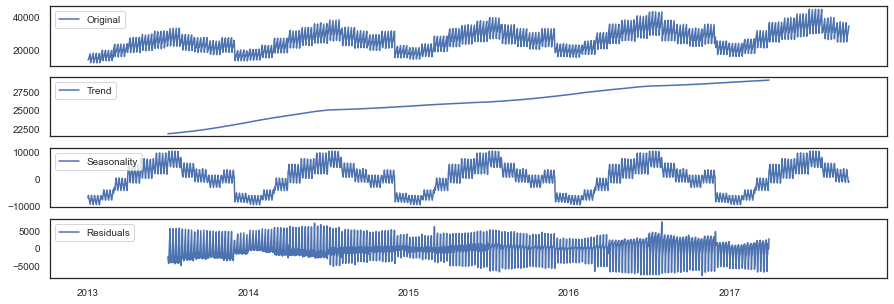

In [83]:
decomposed_sales = decomposed_time_series(df_train.sales, "additive", 365)
decomposed_plots(df_train.sales, decomposed_sales[0], decomposed_sales[1], decomposed_sales[2])

Seasonality plot shows a more complex pattern. Therefore we are going to find a 